In [61]:
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import json
import urllib.request
from sklearn.metrics import r2_score
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
# from sklearn.model_selection import TimeSeriesSplit

In [24]:
# class YoutubeChannel():
#     def __init__(self,ChannelUrl):
#         self.dailySubscribers = allData[["Date","DailySubscribers"]]
#         self.totalSubscribers = allData[["Date","TotalSubscribers"]]
#         self.dailyVideoViews = allData[["Date","DailyVideoViews"]]
#         self.totalVideoViews = allData[["Date","TotalVideoViews"]]
#         self.allData = getAllCharts()

In [25]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [26]:
new_links = ["https://socialblade.com/youtube/user/mmoshaya/monthly",
            "https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
            "https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
            "https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
            "https://socialblade.com/youtube/user/banderitax/monthly",
            "https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [27]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [28]:
# save new req to html file if not found
for i in range(len(new_links)):
    if f"new_req{i}.html" not in os.listdir('.'):
        opener = urllib.request.build_opener()
        opener.addheaders = [('User-agent', 'Mozilla/5.0')]
        response = str(opener.open(new_links[i]).read())
        open("new_req"+str(i)+".html","w").write(response)

In [29]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]
# read files from  disk - files name: new_req0.html .... new_req4.html
new_resText = [open("new_req"+str(i)+".html","r").read() for i in range(len(new_links))]

In [30]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({
        "Date":Date.astype(np.datetime64),
        chart_name:count.astype(np.int64)
        })

In [31]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [32]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [33]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [34]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [35]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [36]:
def getAllCharts_newlinks(response):
    allCharts = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,-?\d+\],?)+\])',response)]
    col = re.findall('title: { text: \\\\\'([\w|\s]+) for',response)
    date1 = pd.Series([i[0] for i in allCharts[0]])
    weeklyGainedSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date1,unit="ms"),#.dt.date, #parse Date from timestamp to date
        col[0]: [i[1] for i in allCharts[0]],
        col[1]: [i[1] for i in allCharts[1]],
    })

    date2 = pd.Series([i[0] for i in allCharts[2]])
    monthlyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date2,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[2]],
        "TotalVideoViews": [i[1] for i in allCharts[3]],
    })

    date3 = pd.Series([i[0] for i in allCharts[4]])
    weeklyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date3,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[4]],
        "TotalVideoViews": [i[1] for i in allCharts[5]],
    })
    return [weeklyGainedSubsAndViews,monthlyTotoalSubsAndViews,weeklyTotoalSubsAndViews]

In [37]:
def concatOldDataWithNew(old_df,new_df):
    concated = pd.concat([old_df[["Date","TotalSubscribers","TotalVideoViews"]],new_df[1],new_df[2]])
    return concated.sort_values(by="Date",ignore_index=True) # sort by date and reset index

In [38]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [39]:
channels_df = [getAllCharts(soup) for soup in soups]

In [40]:
new_channels_df = [getAllCharts_newlinks(r) for r in new_resText]

In [41]:
top1_df = concatOldDataWithNew(channels_df[0], new_channels_df[0]) # top 1 channel df
top2_df = concatOldDataWithNew(channels_df[1], new_channels_df[1]) # top 2 channel df
top3_df = concatOldDataWithNew(channels_df[2], new_channels_df[2]) # top 3 channel df
# top4_df = concatOldDataWithNew(channels_df[3], new_channels_df[3]) # top 4 channel df شلناها لان عدد الروز قليل
top4_df = concatOldDataWithNew(channels_df[4], new_channels_df[4]) # top 4 channel df
top5_df = concatOldDataWithNew(channels_df[5], new_channels_df[5]) # top 4 channel df

In [42]:
top1_df

,Date,TotalSubscribers,TotalVideoViews
0,2016-05-26 00:00:00,576989,157540838
1,2016-05-27 00:00:00,579557,157540838
2,2016-05-28 00:00:00,583261,160354910
3,2016-05-29 00:00:00,586661,160354910
4,2016-05-30 00:00:00,589832,162164368
...,...,...,...
1167,2021-08-21 04:00:00,20700000,14316702181
1168,2021-08-29 04:00:00,20700000,14373671876
1169,2021-09-06 04:00:00,20800000,14431542398
1170,2021-09-14 04:00:00,20800000,14485936904


In [43]:
# top1_df = channels_df[0] # top 1 channel df
# top2_df = channels_df[1] # top 2 channel df
# top3_df = channels_df[2] # top 3 channel df
# # top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
# top4_df = channels_df[4] # top 4 channel df
# top5_df = channels_df[5] # top 4 channel df

In [44]:
# X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
# X_y.columns = ["ds","y"]
# m = Prophet(daily_seasonality=True)
# m.fit(X_y)

In [45]:
# future = m.make_future_dataframe(periods=365)

In [46]:
# forecast = m.predict(future)

In [47]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [48]:
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [49]:
#  m.plot_components(forecast)

In [50]:
# sns.pairplot(top1_df)

In [51]:
# total number of rows
# total = 0
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     total += len(c)
# print(f"the total number of rows is {total}")

In [52]:
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     print(c.info())

In [53]:
# nonZero = channels_df[0][channels_df[0].DailyVideoViews != 0]

In [54]:
# nonZero.join(nonZero.Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [55]:
# channels_df[0].join(channels_df[0].Date.dt.isocalendar()).groupby(["year","week"]).day.count().value_counts()

In [56]:
# iso = channels_df[0].join(channels_df[0].Date.dt.isocalendar())
# # iso.where(iso.day == 1).first_valid_index()
# s = iso[iso.day ==1].iloc[0].name
# e = iso[iso.day ==7].iloc[-1].name


In [57]:
# iso.iloc[s:e+1].groupby(["year","week"]).day.count().value_counts()

In [58]:
# (new_channels_df[0][0].Date.dt.isocalendar().day == 1).value_counts()

In [69]:
ys_yhats = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
            ############# Training #############
    future = md.make_future_dataframe(0)
    forecast = md.predict(future)
    ys_yhats.append(X_y.merge(forecast[["ds","yhat"]],on="ds"))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [60]:
df_cv = []
for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
    X_y = c[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
    X_y.columns = ["ds","y"]
    md = Prophet()
    md.fit(X_y.drop_duplicates(subset="y"))
        ############ Validation #############
    df_cv.append(cross_validation(md,horizon = '170 days'))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-16 04:00:00 and 2021-03-20 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-31 04:00:00 and 2021-04-04 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Making 14 forecasts with cutoffs between 2018-03-19 04:00:00 and 2021-03-28 04:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 15 forecasts with cutoffs between 2017-12-24 04:00:00 and 2021-03-28 04:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 13 forecasts with cutoffs between 2018-06-19 04:00:00 and 2021-04-04 04:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

## Validation Plots

0.9859983658404097
0.9922268014750664
0.9773864961547822
0.9807096105368093
0.9839014307188388


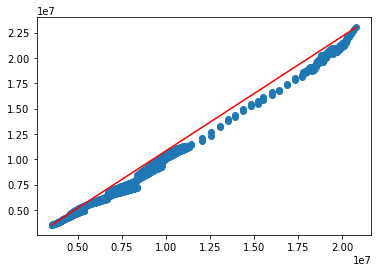

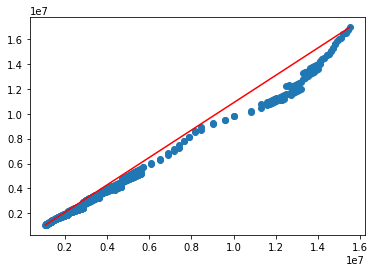

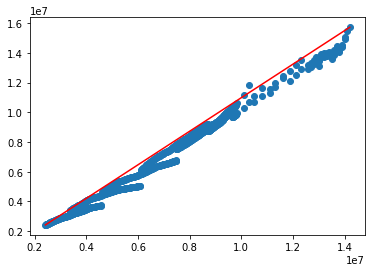

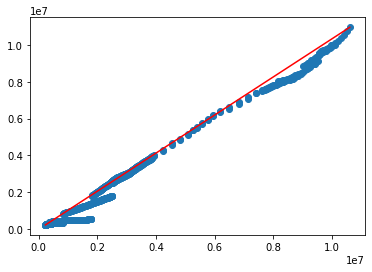

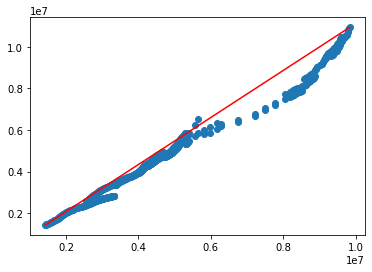

<Figure size 432x288 with 0 Axes>

In [68]:
for df in df_cv:
    plt.scatter(df.y,df.yhat)
    x_plt_range = [df.y.min(),df.y.max()]
    y_plt_range = [df.yhat.min(),df.yhat.max()]
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.figure()
    print(r2_score(df.y,df.yhat))
#     plot_cross_validation_metric(df, metric='mae')

## Training Plots

0.9988892876560596
0.999303402122512
0.9997237512039455
0.9998401720840386
0.9990697991832899


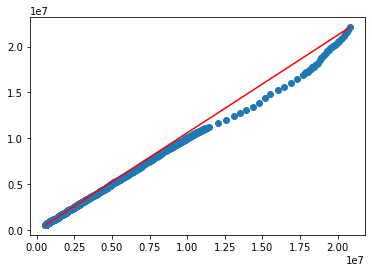

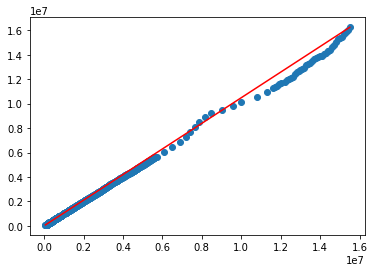

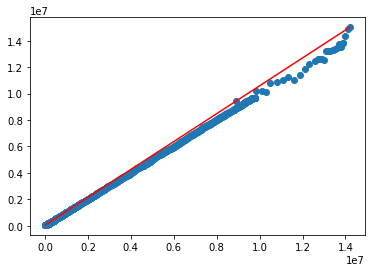

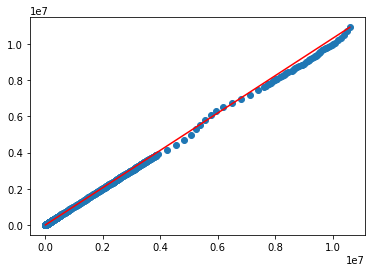

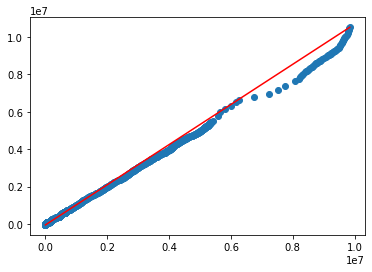

<Figure size 432x288 with 0 Axes>

In [71]:
for y_yhat in ys_yhats:
    print(r2_score(y_yhat["y"],y_yhat["yhat"]))
    plt.scatter(y_yhat["y"],y_yhat["yhat"])
    x_plt_range = [y_yhat["y"].min(),y_yhat["y"].max()]
    y_plt_range = [y_yhat["yhat"].min(),y_yhat["yhat"].max()]
    plt.plot(x_plt_range,y_plt_range,c="r")
    plt.figure()

In [63]:
# tss = TimeSeriesSplit()
# for tarin,val in tss.split(X_y):
md = Prophet()
md.fit(X_y)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
# for train,val in kf:
#     print("train Range:",min(train),max(train),"val Range:",min(val),max(val))
X_y.ds

0      2016-05-26 00:00:00
1      2016-05-27 00:00:00
2      2016-05-28 00:00:00
3      2016-05-29 00:00:00
4      2016-05-30 00:00:00
               ...        
1158   2021-06-26 04:00:00
1161   2021-07-12 04:00:00
1163   2021-07-28 04:00:00
1166   2021-08-13 04:00:00
1169   2021-09-06 04:00:00
Name: ds, Length: 1132, dtype: datetime64[ns]

In [72]:
df_cv = cross_validation(md,initial='730 days', period='100 days', horizon = '200 days')

INFO:prophet:Making 10 forecasts with cutoffs between 2018-09-02 04:00:00 and 2021-02-18 04:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-09-03 00:00:00,6.758588e+06,6.750987e+06,6.765759e+06,6761503,2018-09-02 04:00:00
1,2018-09-04 00:00:00,6.773714e+06,6.766486e+06,6.780681e+06,6774268,2018-09-02 04:00:00
2,2018-09-05 00:00:00,6.789115e+06,6.781420e+06,6.796180e+06,6788357,2018-09-02 04:00:00
3,2018-09-06 00:00:00,6.804140e+06,6.796606e+06,6.812681e+06,6801848,2018-09-02 04:00:00
4,2018-09-07 00:00:00,6.819345e+06,6.811280e+06,6.826723e+06,6816766,2018-09-02 04:00:00
...,...,...,...,...,...,...
505,2021-06-26 04:00:00,2.220185e+07,2.179042e+07,2.271235e+07,20400000,2021-02-18 04:00:00
506,2021-07-12 04:00:00,2.246592e+07,2.197122e+07,2.309994e+07,20500000,2021-02-18 04:00:00
507,2021-07-28 04:00:00,2.271259e+07,2.209660e+07,2.343322e+07,20600000,2021-02-18 04:00:00
508,2021-08-13 04:00:00,2.290395e+07,2.217465e+07,2.370072e+07,20700000,2021-02-18 04:00:00


In [52]:
import matplotlib.pyplot as plt

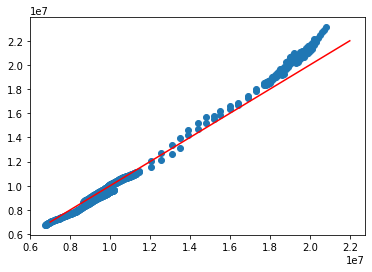

In [74]:
plt.scatter(df_cv.y,df_cv.yhat)
plt.plot([0.7e7,2.2e7],[0.7e7,2.2e7],c="r")

In [75]:
r2_score(df_cv.y,df_cv.yhat)

0.9777731069726776

In [44]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,17 days 20:00:00,1.575681e+10,1.255261e+05,8.580407e+04,0.008256,0.008152,0.008269,0.000000
1,18 days 20:00:00,1.602467e+10,1.265886e+05,8.782004e+04,0.008492,0.009218,0.008507,0.000000
2,19 days 20:00:00,1.631041e+10,1.277122e+05,8.987963e+04,0.008751,0.010806,0.008768,0.000000
3,20 days 20:00:00,1.660390e+10,1.288561e+05,9.192099e+04,0.008983,0.011645,0.009002,0.000000
4,21 days 20:00:00,1.688437e+10,1.299399e+05,9.385264e+04,0.009196,0.011786,0.009217,0.000000
...,...,...,...,...,...,...,...,...
328,354 days 01:00:00,3.979097e+12,1.994767e+06,1.896749e+06,0.099610,0.107500,0.095077,0.619048
329,358 days 00:00:00,4.067772e+12,2.016872e+06,1.914397e+06,0.100470,0.109103,0.095842,0.642857
330,362 days 00:00:00,4.086479e+12,2.021504e+06,1.918360e+06,0.100783,0.109103,0.096121,0.666667
331,364 days 00:00:00,4.086051e+12,2.021398e+06,1.918139e+06,0.100556,0.109103,0.095877,0.666667


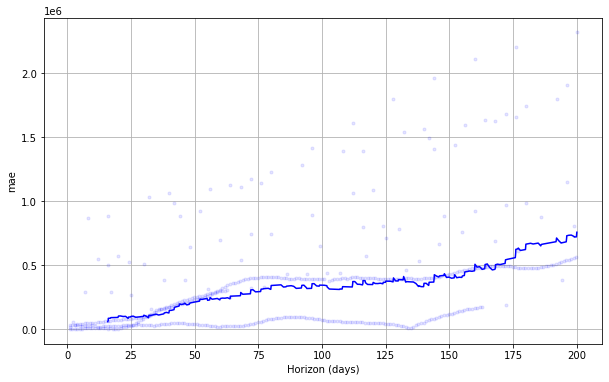

In [76]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [46]:
future = md.make_future_dataframe(periods=365)

In [47]:
future

,ds
0,2016-05-26 00:00:00
1,2016-05-27 00:00:00
2,2016-05-28 00:00:00
3,2016-05-29 00:00:00
4,2016-05-30 00:00:00
...,...
1530,2022-09-17 04:00:00
1531,2022-09-18 04:00:00
1532,2022-09-19 04:00:00
1533,2022-09-20 04:00:00


In [48]:
forecast = md.predict(future)

In [49]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1530,2022-09-17 04:00:00,2.605738e+07,2.450526e+07,2.757533e+07
1531,2022-09-18 04:00:00,2.607115e+07,2.451700e+07,2.760443e+07
1532,2022-09-19 04:00:00,2.607473e+07,2.453692e+07,2.759310e+07
1533,2022-09-20 04:00:00,2.608787e+07,2.455196e+07,2.765913e+07
1534,2022-09-21 04:00:00,2.611821e+07,2.450147e+07,2.763241e+07


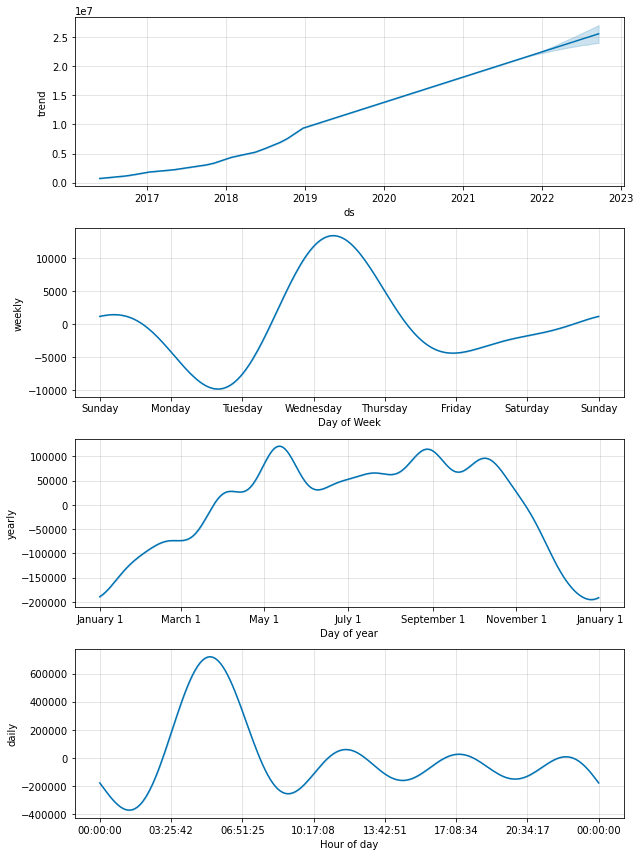

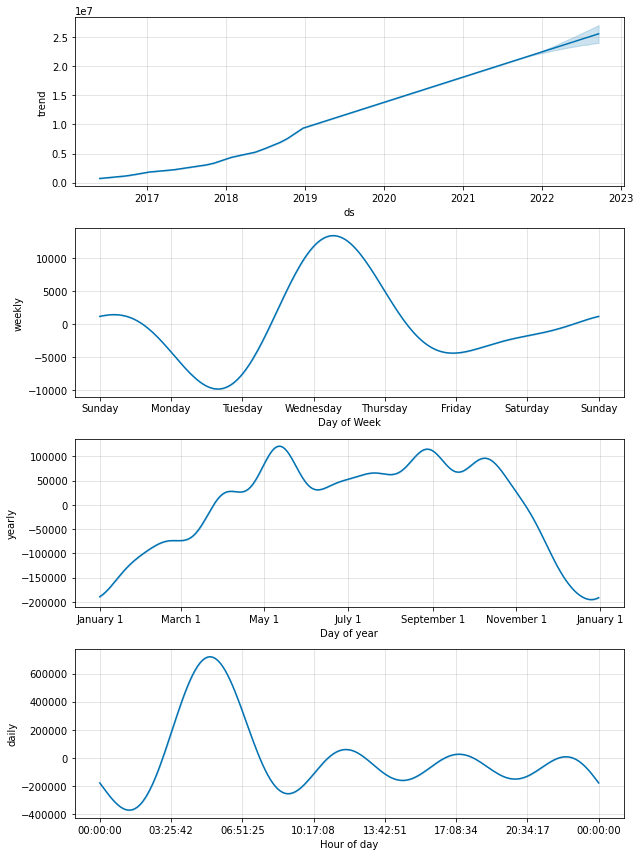

In [50]:
 md.plot_components(forecast)

In [51]:
y_yhat = top1_m.merge(forecast[["ds","yhat"]],left_on="Date",right_on="ds")
r2_score(y_yhat["TotalVideoViews"],y_yhat["yhat"])

NameError: name 'top1_m' is not defined

In [ ]:
r2_score()

In [ ]:
df1[(df1["Weekly Subscribers Gained"] == 100000)]

# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)